## Simulation Tests

Fixed conditions comprise of sampling time (1600 timesteps to reflect 20 minute flight in seconds), survey area (7500m x 7500m) and sensor detection zone (based on camera model). Changing variables per flight will reflect survey effort and animal availability:

1.Survey Effort

* UAV path (Lawn-mower/ Figure 8)
* FOV (BIOT/ Maldives)
* UAV speed (lowest speed-average/ average-max speed)

2.Animal availability

* Animal movement model (Straight Line/ Stop-Start/ Random Walk)
* Animal speed (different per taxa)
* Availability bias (None/Sharks/Rays/Birds)


### Parameter Functions
These functions include:
* Selecting detection zone
* Start coord of UAV depending on camera type
* Establishing seperate speed profiles
* Sample points - number of coordinates and x, y values between 2 points in flight path

In [6]:
def detection_zone(camera):
    # FOV calculated per camera model in Strip_Sampling_Density.
    
    camdict = {"garmin": [83,113], "sony": [113, 75]}
    try:
        return camdict[camera.lower()]
    except KeyError:
        raise KeyError ('Invalid camera model used, should be :{}'.format([x for x in camdict.keys()]))

In [7]:
detection_zone('GARMIN')

[83, 113]

In [8]:
def boundary_coords_uav(camera):
    
    # x and y coordinates 
    
    area = detection_zone(camera)
    half_area = [x/2  for x in area]
    boundary = {'coord_1' : [(0 + half_area[0]), (0 + half_area[1])],
                'coord_2' : [(7500 - half_area[0]), (0 + half_area[1])],
                'coord_3' : [(7500 - half_area[0]), (7500 - half_area[1])],
                'coord_4' : [(0 + half_area[0]), (7500 - half_area[1])]}
    
    return boundary

boundary_coords_uav('sony')

{'coord_1': [56.5, 37.5],
 'coord_2': [7443.5, 37.5],
 'coord_3': [7443.5, 7462.5],
 'coord_4': [56.5, 7462.5]}

In [286]:
from scipy.stats import truncnorm
import scipy.stats as stats
import matplotlib.pyplot as plt

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    # More intuitive method to use truncnorm for speed_profile distribution

    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)



def speed_profile (level = 0, mean = 18, sd = 1, low = 4, upp = 33):
    # Speed profile for random sample distribution
    # Average speed: 18 m/s 
    # Level 1 = low, Level 2 = high
    
    speed_dist = get_truncated_normal(mean, sd, low, upp)
    value = speed_dist.rvs(size=1) # Select 1 random number from this distribution
    
    if level == 1:
        while value > mean:
            value = speed_dist.rvs(size=1)


    elif level == 2:
        while value < mean:
            value = speed_dist.rvs(size=1)

    else:
        value = ('You have not selected correct uav level, must be 1 or 2', 0)
    
    return value[0]
        

# Show graphics
#lower, upper = 4, 33
#mu, sigma = 18, 2
#X = stats.truncnorm(
#    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#N = stats.norm(loc=mu, scale=sigma)

#fig, ax = plt.subplots(2, sharex=True)
#ax[0].hist(X.rvs(10000), normed=True) # truncated normal dist
#ax[1].hist(N.rvs(10000), normed=True) # normal dist
#plt.show()

speed_profile(2)

18.343361021861135


### Speed profiles of animal

#### Elasmos & Mammals
1.  Grey reef shark (Ryan, 15)
Cruise speed - 0.64m/s | max cruise speed - 1.23 | sd - 1.23-0.35/4

2. Nurse shark (Whitney, 16)
Cruise speed is 0.33Bl/s - 0.37m/s (Mean of the mean swimming speeds in 21 - 30 degree water) ((((91+132)/2)/100)*0.33) | max - ((132/100)*0.42) (Mximum speed range with maximum body size). | sd -  (0.59 - ((91/100)*0.23))/ 4 

3. Whale shark (Jacoby,18)
Cruise speed is 0.6m/s | max - 1.06 | 1.06-0.09/4 

4. Mantaray (using for eagleray) (Fish, 18)  
Cruise speed is 1.42 m/s | max - 2.51 | 2.51-0.46/4

5. Manatee speed (Kojeszewski, 07)
Cruise speed is 0.7m/s | max - 1.14 | 1.14-0.06/4

#### Birds
1. Red-footed boobies (Weimerskirch, 05)
Median speed of 38km/h - 10.5m/s | max - 22m/s | 22-2.7/4

2. Frigatebird (Weimerskirch,03)
Average speed is 16.4km/h - 4.5 m/s | max - 5.1m/s | 5.1-2.7/4

3. Common tern average (Hedenstrom,16)
Average is 8.5 m/s | max - 10m/s | 10-7/4

#### Calculating standard deviation

Rough estimate of standard deviation derived from the range rule for standard deviation;

$$\frac {Maximum - Minimum}{4} $$

Why 4? 95% of the data will fall within 2 standard deveiations either side of the mean and so nearly all of our normal distribution will stretch over 4 standard deviations (Wan, 14).


In [16]:
from matplotlib import pyplot as plt
import statistics
import math


def animal_speed (animal):
    # Speed distribution is based on crude figures for each animal taxa
    
    speed_dict = {"reef": [0.35, 0.64, 1.23, 0.22], "nurse": [0.21, 0.37, 0.59, 0.1], "whale_shark" : [0.09, 0.6, 1.06, 0.24], "ray": [0.046, 1.42, 2.51, 0.5], 
                  "manatee": [0.06, 0.7, 1.14, 0.27], "booby": [2.7, 10.5, 22, 4.82], "frigate": [2.7, 4.5, 5.1, 0.6], "tern": [7, 8.5, 10, 0.75]}
    
    try:
        x =  speed_dict[animal.lower()]
        mean = x[1]
        upp = x[2]
        sd = x[3]
        low = x[0]
        speed_dist = get_truncated_normal(mean, sd, low, upp)
        value = speed_dist.rvs(size=1)
        return value[0]
    
    except KeyError:
        raise KeyError ('Invalid animal species, please try again')
                        
    #fig, ax = plt.subplots(1, sharex=True)
    #ax.hist(speed_dist.rvs(1000), normed=True)
    #ax.set_title(animal)
    #plt.show()
    



In [197]:
animal_speed('booby')

5.3737978859736852

In [13]:
import math
import numpy as np


def round_up(n, decimals=2):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def get_speed(individual, level = 0):
    
    # Speed retrieved depending on which object we are simulating
    # individual = string of uav or animal

    if individual == 'uav':
        s = speed_profile(level)
    else:
        s = animal_speed(individual)
        
    return s


def find_sample_points(start_coord, end_coord, angle, individual, speed_level = 0, probability = 0):

    # Retrieves coordinates for x number of timesteps between 2 points
    
    # start_coord = start point of animal or drone
    # end_coord = end point of animal or drone
    # angle = angle of travel in degrees
    # individual = animal or drone?
    # speed_level = low(1) or high(2)
    # probability = probability of animal remaininh stationary in that timestep(default = 0)
    
    
    horiz_dist = abs(end_coord[0] - start_coord[0]) # x coordinates
    vert_dist = abs(end_coord[1] - start_coord[1]) # y coordinates
    length = math.sqrt((horiz_dist**2) + (vert_dist**2)) # length in metres between both points
    angle_radians = math.radians(angle)

    
    total_length_covered = 0
    x_list = [start_coord[0]] # list of x values at every step
    y_list = [start_coord[1]] # list of y values at every step
    iteration = 0 # used to cumulatively add the last x, y values to recent

    while True:
        s = get_speed(individual, speed_level) # get our speed for this step
        total_length_covered += s # cumulatively add to total length covered
        #print(total_length_covered)
        if total_length_covered > length:
            break
        
        point_probability = np.random.choice(100,1) # assign probability to coordinate
        #print(point_probability)
        if point_probability > probability:
            delta_x = x_list[iteration] + (math.cos(angle_radians)* s) # From start x coordinate, add the length with direction calculated through cosine 
            delta_y = y_list[iteration] + (math.sin(angle_radians)* s) # From start y coordinate, add the length with direction calculated through sine
          
            x = round_up(delta_x)
            y = round_up(delta_y)
            
            x_list.append(x) 
            y_list.append(y)
        
        else:
            total_length_covered = total_length_covered - s # Take last distance as we have not travelled here
            x_list.append(x_list[iteration]) 
            y_list.append(y_list[iteration])

        iteration += 1


    sample_coords = list(zip(x_list, y_list))     # zip up to create list of tuples, each being a set of coordinates where a sample has been taken
    
    Actual_length = total_length_covered - s
    
    
    return sample_coords 



In [11]:
#test = find_sample_points([100,0], [0,0], 180, 'uav',1)
#test

In [19]:
def angle_dist(angle):
    
    # Sampling from a uniform distribution between a chosen angle range
    
    low = -(angle)
    high = angle
    t = np.random.uniform(low = low, high = high, size = 1000)
    
    plt.hist(t, bins=25, color='#75BEBB')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.xlim([low - 10, high +10])
    plt.ylim([0, 75])
    plt.show()
    
    return t


def random_walk (start_coord, angle, timestep = 1600):
    
    # Correlated random walk with a start coordinate and angle to bound normal dist
    
    angle_value = angle_dist(angle)
    
    angle_radians = math.radians(angle_value)
    
    x_list = [start_coord[0]] # list of x values at every step
    y_list = [start_coord[1]] # list of y values at every step
    iteration = 0
    
    for i in range(timestep):
        delta_x = x_list[iteration] + (math.cos(angle_radians)* s) # From start x coordinate, add the length with direction calculated through cosine 
        delta_y = y_list[iteration] + (math.sin(angle_radians)* s) # From start y coordinate, add the length with direction calculated through sine
       
        x = round_up(delta_x)
        y = round_up(delta_y)
            
        x_list.append(x) 
        y_list.append(y)
        
        iteration += 1
    
     
     
    sample_coords = list(zip(x_list, y_list))     # zip up to create list of tuples, each being a set of coordinates where a sample has been taken
    
    return sample_coords 


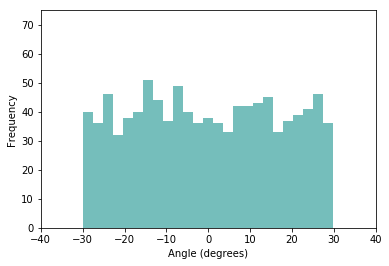

array([  7.53839846e-01,  -2.21867560e+01,  -2.00018990e+01,
         3.82679847e+00,   1.02008962e+01,  -1.09295898e+01,
         1.18155272e+01,  -1.63656341e+01,   1.41175604e+01,
        -1.02893646e+01,   2.49136621e+01,  -2.95204780e+00,
        -2.80951136e+01,  -3.92582783e+00,  -7.48925099e+00,
         1.10622314e+01,  -2.74579795e+01,  -5.87087531e+00,
        -4.54398096e-01,  -1.46510560e+01,   2.34694445e+01,
        -1.47871893e+01,   5.45764895e+00,   6.39816670e+00,
        -2.00243158e+01,   1.42928691e+01,   1.58912645e+01,
         1.39243539e+00,   1.53396347e+01,   1.40490018e+01,
        -2.81375631e+01,  -1.31522389e+01,   1.47620303e+01,
         1.61095543e+01,   2.15022692e+01,   1.55996653e+01,
        -1.46305801e+01,   2.03687738e+01,   2.73494231e+01,
        -2.92726921e+01,   1.65284249e+01,   3.55898719e+00,
         2.86974162e+01,   1.35793179e+01,   5.78431910e+00,
        -2.64847842e+00,  -2.38125362e+01,   2.05550229e+01,
         2.09498043e+01,

In [20]:
#random_walk([100,200], 45)
angle_dist(30)

### UAV and Animal path functions

In [318]:
for i in range(1600):

SyntaxError: unexpected EOF while parsing (<ipython-input-318-d5702987f29f>, line 1)